### import thư viện

In [1]:
import numpy as np
import os
import sys
import time
import pandas as pd
import logging
import pickle
from tqdm._tqdm_notebook import tqdm_notebook
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


Using TensorFlow backend.


### Khai báo Hằng số

In [2]:
TIME_STEPS = 60
BATCH_SIZE = 20
LR = 0.00010000
EPOCHS  = 300

### Cấu hình các đường dẫn vào và ra

In [3]:
iter_changes = "dropout_layers_0.1_0.1"
INPUT_PATH = "inputs"
OUTPUT_PATH = "outputs/"
stime = time.time()

### Chức năng 

##### Hiển thị thời gian chạy

In [4]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutos : ",np.round(seconds%60),"segundos")

##### Cắt tập dữ liệu thành kích thước chia hết cho BATCH_SIZE

In [5]:
def trim_dataset(mat,batch_size):
    """
    
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

##### huyển đổi ndarray sang định dạng timeeries và định dạng dữ liệu được giám sát. Lấy TIME_STEPS số dòng đầu tiên làm đầu vào và xác định TIME_STEPS + dữ liệu thứ nhất làm đầu ra tương ứng, v.v. Trả về hai ndarrays: đầu vào và đầu ra ở định dạng thích hợp để cấp LSTM.

In [6]:
def build_timeseries(mat, y_col_index):

    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

        print("Comprimento das séries temporais de entrada e saída",x.shape,y.shape)
    return x, y

### Xử lý thông tin

#### Tệp dữ liệu này chứa khoảng 55 năm dữ liệu giá cổ phiếu của GE cho Hoa Kỳ.

In [ ]:
stime = time.time()
print(os.listdir(INPUT_PATH))
df_ge = pd.read_csv(os.path.join(INPUT_PATH, "ge.us.txt"), engine='python')
print(df_ge.shape)
print(df_ge.columns)
display(df_ge.head(5))
tqdm_notebook.pandas('Processando...')
print(df_ge.dtypes)
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Tamanho Train--Test", len(df_train), len(df_test))
print("Tamanho total", len(df_train) + len(df_test))

['ge.us.txt']
(14058, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Tamanho Train--Test 11246 2812
Tamanho total 14058


#### Có khoảng 14060 mặt hàng, mỗi mặt hàng đại diện cho các thuộc tính của một ngày thị trường chứng khoán cho công ty.

### Vẽ lịch sử giá cổ phiếu của GE trên biểu đồ

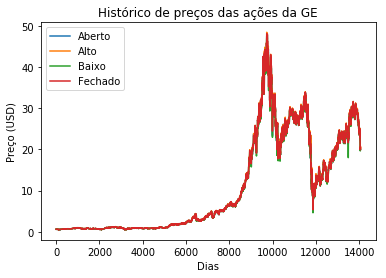

In [ ]:
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('Histórico de preços das ações da GE')
plt.ylabel('Preço (USD)')
plt.xlabel('Dias')
plt.legend(['Aberto','Alto','Baixo','Fechado'], loc='upper left')
plt.show()

#### Giá - Mở cửa, Đóng cửa, Thấp, Cao - không thay đổi nhiều với nhau, ngoại trừ các đợt giảm giá nhỏ không thường xuyên trong Giá Thấp

### Biểu đồ cho khối lượng

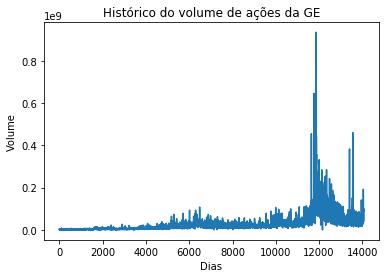

In [ ]:
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('Histórico do volume de ações da GE')
plt.ylabel('Volume')
plt.xlabel('Dias')
plt.show()

#### Có một sự gia tăng đáng kể về số lượng giao dịch trong khoảng 12000 ngày trên dòng thời gian, trùng với sự sụt giảm đột ngột của giá cổ phiếu.

### Xác định kích thước tính năng MinMax, xây dựng mảng

In [ ]:
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

In [ ]:
print("Excluindo dataframes não utilizados de tamanho total (KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)


Excluindo dataframes não utilizados de tamanho total (KB) 3267


In [ ]:
del df_ge
del df_test
del df_train
del x

In [ ]:
print("Existem NaNs presentes nos arrays",np.isnan(x_train).any(), np.isnan(x_train).any())


Existem NaNs presentes nos arrays False False


In [ ]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

dim_0 11186


Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento das séries temporais de entrada e saída (11186, 60, 5) (11186,)
Comprimento 

### Tạo mô hình

In [ ]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=LR)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

### Kiểm tra xem mô hình có tồn tại không

In [ ]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Modelo salvo carregado...")
except FileNotFoundError:
    print("Modelo não encontrado")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Modelo salvo carregado...


In [ ]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Tamanho do teste", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


dim_0 2752


Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de entrada e saída (2752, 60, 5) (2752,)
Comprimento das séries temporais de en

### 
Xây dựng mô hình nếu nó không tồn tại

In [ ]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Construindo o modelo...")
    print("Verificando se a GPU está acessível", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    history = model.fit(x_t, y_t, epochs=EPOCHS, verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Construindo o modelo...
Verificando se a GPU está acessível []
Train on 11180 samples, validate on 1360 samples
Epoch 1/300
 - 130s - loss: 0.0215 - val_loss: 0.0503

Epoch 00001: val_loss improved from inf to 0.05030, saving model to outputs/best_model.h5
Epoch 2/300
 - 75s - loss: 0.0119 - val_loss: 0.0085

Epoch 00002: val_loss improved from 0.05030 to 0.00847, saving model to outputs/best_model.h5
Epoch 3/300
 - 76s - loss: 0.0028 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00847 to 0.00191, saving model to outputs/best_model.h5
Epoch 4/300
 - 75s - loss: 0.0021 - val_loss: 0.0015

Epoch 00004: val_loss improved from 0.00191 to 0.00148, saving model to outputs/best_model.h5
Epoch 5/300
 - 76s - loss: 0.0018 - val_loss: 0.0014

Epoch 00005: val_loss improved from 0.00148 to 0.00139, saving model to outputs/best_model.h5
Epoch 6/300
 - 75s - loss: 0.0016 - val_loss: 0.0013

Epoch 00006: val_loss improved from 0.00139 to 0.00132, saving model to outputs/best_model.h5
Epo